# 2/22/21 - This notebook applies LightAndMassProfiles and dark matter profiles to the fit.
https://github.com/Jammy2211/autolens_workspace/blob/release/notebooks/imaging/modeling/light_parametric__mass_light_dark__source_parametric.ipynb

In [1]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'
object_folder = f'{fits_path}G3575500_1906/'

In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /soft/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_tes

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Lens and source redshifts at [0.2325366] and [0.36519459].
Einstein radius prior: [1.02937223]
Plotting r-band


/soft/anaconda3/lib/python3.7/site-packages/autoarray/dataset/abstract_dataset.py:88: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / self.noise_map


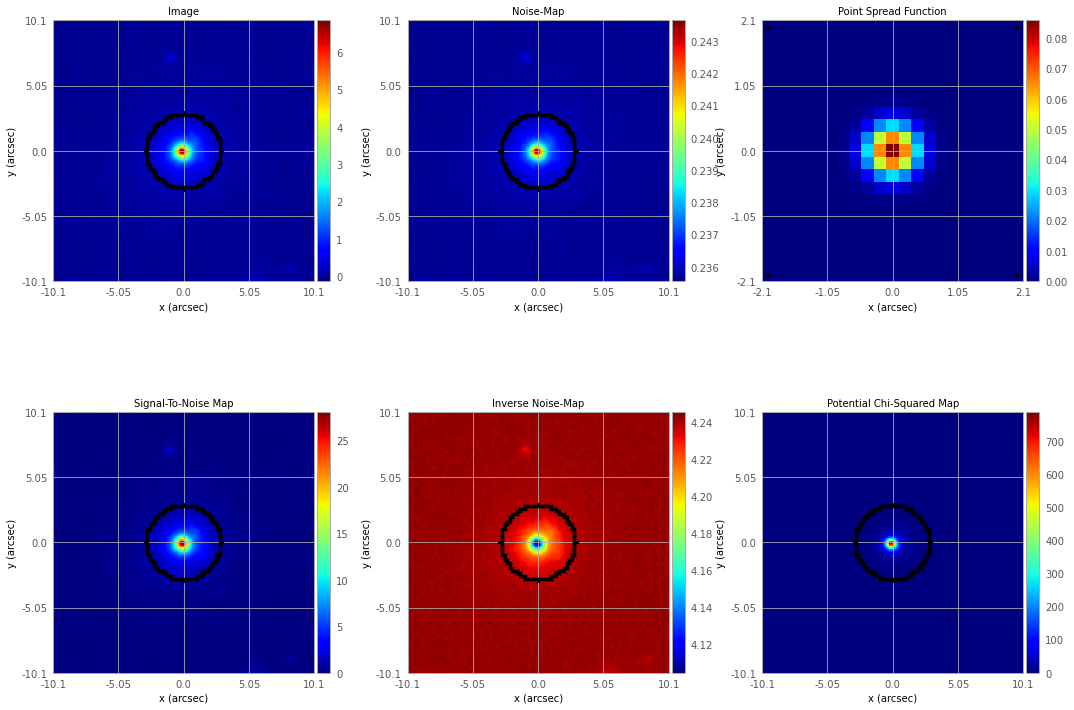

Plotting g-band


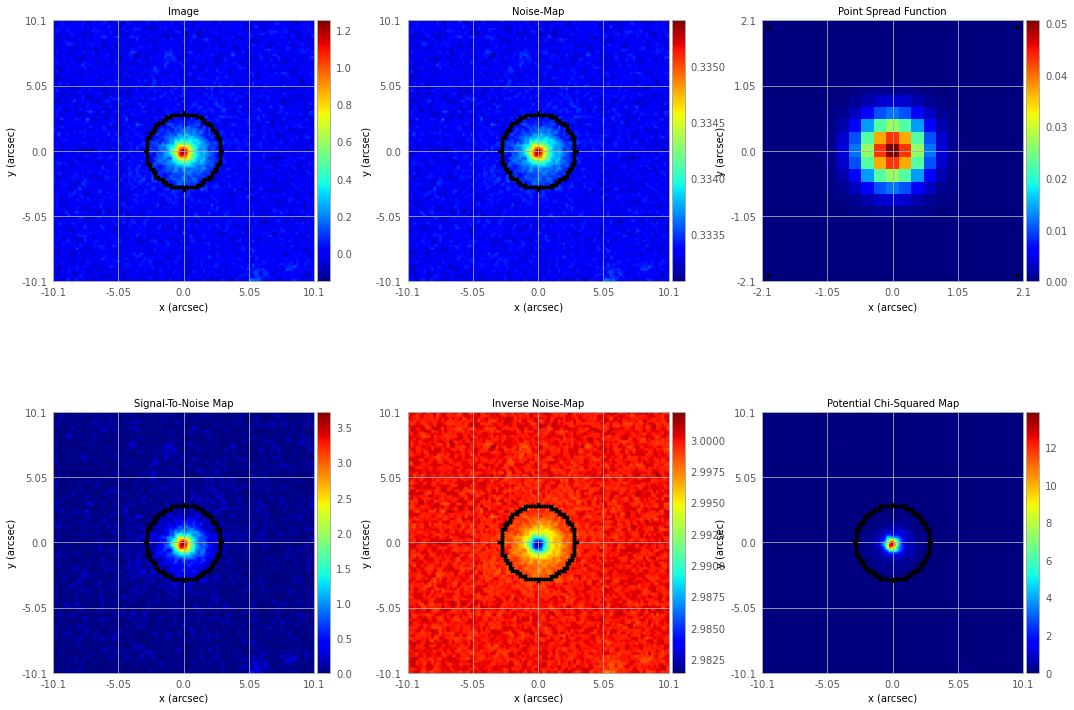

In [2]:
# this should be constant across experiments

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == 3575500]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=(lens_galaxy_data.theta_e_pm.values+lens_galaxy_data.theta_e_sis.values)/2 # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, '1906_r_image.fits'),
                              noise_map_path=path.join(object_folder, '1906_r_noisemap.fits'),
                              psf_path=path.join(object_folder, '1906_r_psf_resized.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

# load g-band imaging
imaging_g = al.Imaging.from_fits(image_path=path.join(object_folder, '1906_g_image.fits'),
                              noise_map_path=path.join(object_folder, '1906_g_noisemap.fits'),
                              psf_path=path.join(object_folder, '1906_g_psf_resized.fits'),
                               pixel_scales=0.2)
# same mask
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.subplot_imaging()

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=3.0)

In [4]:
# set up tools for tracking the experiments (log of outputs and table of time to convergence and log likelihood)

#Start a log.txt file
log = open(f"{autoz_path}output/G3575500/dark_experiment_log_G3575500", 'w')
log.write(f'This logs the outputs from autolens experiments on G3575500_1906 beginning on datetime {datetime}. PARTY ON WAYNE! \n')
log.write(f'\n')
log.close()

# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G3575500_performance_log.csv')
print(performance_log)

    Unnamed: 0 Experiment  phase1_time  phase1_time.1  phase2_time  \
0            0        1-1   107.555079     296.239404   167.684566   
1            0        1-2   137.521799     296.010310   143.622440   
2            0        1-3   104.364316     296.235893   206.749381   
3            0        1-4    73.453015     296.132388   132.761242   
4            0        1-5    40.029995     296.179939    98.284560   
5            0        1-6    34.548316     286.543298    65.271374   
6            0        1-7    11.370712    -208.230643    22.767801   
7            0        2-1    31.438987     293.256161    74.863757   
8            0        2-2    30.512206     290.287783    69.753079   
9            0        2-3    33.163424     294.155040    67.388101   
10           0        2-4    34.001947     295.772725    66.217120   
11           0        2-5    34.957396     294.779695    97.963022   
12           0        3-1    33.795533     295.262757    77.247186   
13           0      

## Experiment 1: Dark matter

In [5]:
# set experiment number
experiment_number = '1-DM-positions'

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500", name=f"experiment_{experiment_number}_r_fit_{datetime}", n_live_points=40,
        evidence_tolerance=1
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

In [6]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Dynesty samples found, beginning new non-linear search. 
168it [00:08, 17.50it/s, bound: 4 | nc: 5 | ncall: 1630 | eff(%): 10.307 | loglstar:   -inf < -1692.403 <    inf | logz: -1700.933 +/-  0.649 | dlogz: 1612.309 >  1.000] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
179it [00:08, 24.02it/s, bound: 6 | nc: 5 | ncall: 1695 | eff(%): 10.560 | loglstar:   -inf < -1515.898 <    inf | logz: -1524.700 +/-  0.659 | dlogz: 1391.942 >  1.000]/soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
216

Work complete! Took us 66.87454798817635 seconds or 1.114575799802939 minutes.


Log likelihood: 295.9838458826517


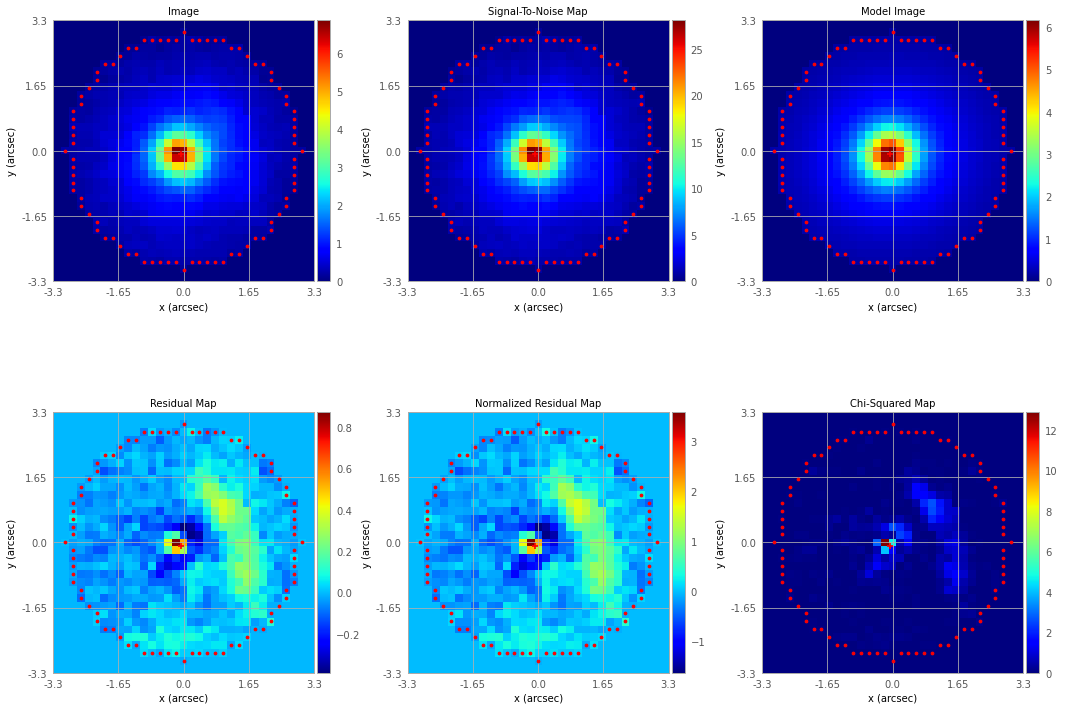

In [9]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [11]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.dark.centre = lens.bulge.centre

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=3.0)

Plotting g-band


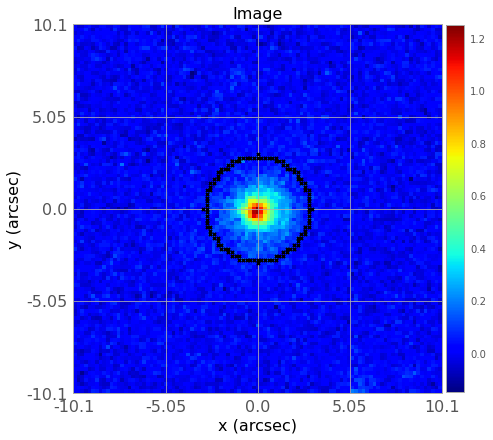

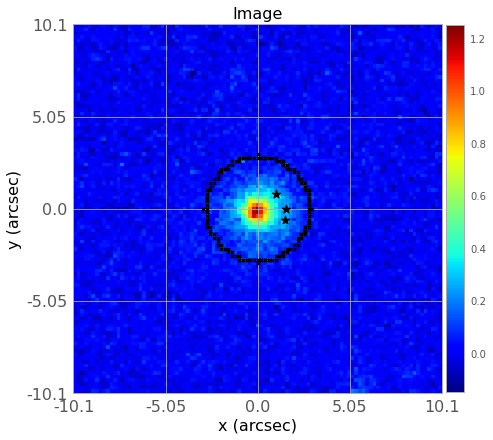

In [12]:
# Set up the positions... (GUI is not working...)

# plot the g-band image to see it
print('Plotting g-band')
imaging_plotter_g = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_g, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_g.figures(image=True)

# set positions
imaging_g.positions = al.Grid2DIrregular(
    [(0.0, 1.55), (-0.6, 1.5), (0.8, 1.0)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_g.positions)
imaging_plotter_g = aplt.ImagingPlotter(imaging=imaging_g, visuals_2d=visuals_2d)
imaging_plotter_g.figures(image=True)

In [13]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=2.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [14]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="G3575500", name=f"experiment_{experiment_number}_g_fit_{datetime}", n_live_points=40,
        evidence_tolerance=0.5, walks=5, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [15]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_g, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.


Phase running...


INFO:root:No Dynesty samples found, beginning new non-linear search. 
337it [02:14,  2.51it/s, +40 | bound: 48 | nc: 1 | ncall: 2542 | eff(%): 14.831 | loglstar:   -inf < 117.938 <    inf | logz: 110.154 +/-  0.569 | dlogz:  0.014 >  0.500]   
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
345it [00:03, 113.70it/s, +40 | bound: 50 | nc: 1 | ncall: 2582 | eff(%): 14.911 | loglstar:   -inf < 117.953 <    inf | logz: 110.167 +/-  0.571 | dlogz:  0.012 >  0.500]
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
345it [00:00, 165280.97it/s, +40 | bound: 50 | nc: 1 | ncall: 2582 | eff(%): 14.911 | loglstar:   -inf < 117.953 <    inf | logz: 110.167 +/-  0.571 | dlogz:  0.012 >  0.500]
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:10000 Iterations: Performing update (Visualization, outputting samples, etc.).


Work complete! Took us 184.56035600602627 seconds or 3.076005933433771 minutes.


In [16]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')

phase2_time=tock-tick

log = open(f"{autoz_path}output/G3575500/experiment_log_G3575500", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

Log likelihood: 117.9533244318492


    Unnamed: 0      Experiment  phase1_time  phase1_time.1  phase2_time  \
0          0.0             1-1   107.555079     296.239404   167.684566   
1          0.0             1-2   137.521799     296.010310   143.622440   
2          0.0             1-3   104.364316     296.235893   206.749381   
3          0.0             1-4    73.453015     296.132388   132.761242   
4          0.0             1-5    40.029995     296.179939    98.284560   
5          0.0             1-6    34.548316     286.543298    65.271374   
6          0.0             1-7    11.370712    -208.230643    22.767801   
7          0.0             2-1    31.438987     293.256161    74.863757   
8          0.0             2-2    30.512206     290.287783    69.753079   
9          0.0             2-3    33.163424     294.155040    67.388101   
10         0.0             2-4    34.001947     295.772725    66.217120   
11         0.0             2-5    34.957396     294.779695    97.963022   
12         0.0           

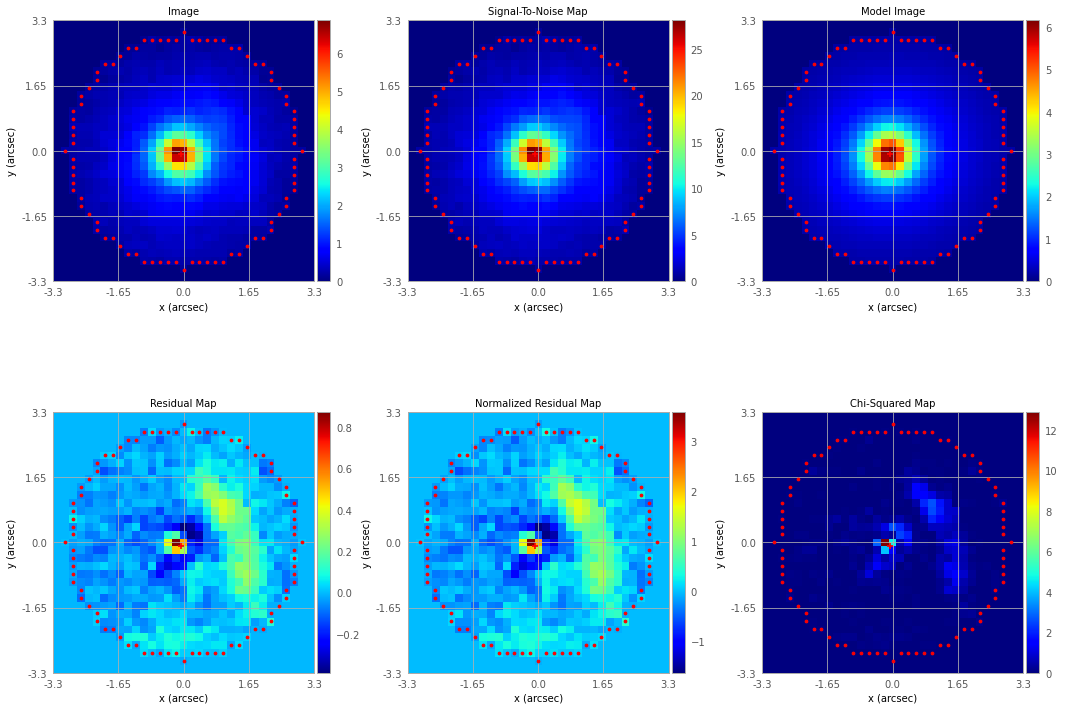

In [17]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood, 
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [20]:
phase2.result.Galaxies]

TypeError: 'PromiseResult' object is not subscriptable